## Imports

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cv2
import gzip
import os
import sys
import struct
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Data processing

In [2]:
def get_and_process_data(path, image_size):
    data_array = os.listdir(path)
    data = list()
    for img in tqdm(data_array):
        try:
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_array = cv2.resize(img_arr, (image_size, image_size))
            #squasing the array in 2D
            reshaped_array = resized_array.reshape(image_size * image_size)
            data.append(reshaped_array)
        except Exception as e:
            print(e)
    return np.array(data)

In [3]:
dataset_location = './dataset'
image_size = 50
train_pneumonia = get_and_process_data(dataset_location+'/train/PNEUMONIA', image_size)
train_normal = get_and_process_data(dataset_location+'/train/NORMAL', image_size)
test_pneumonia = get_and_process_data(dataset_location+'/test/PNEUMONIA', image_size)
test_normal = get_and_process_data(dataset_location+'/test/NORMAL', image_size)


 57%|█████▋    | 2228/3876 [00:21<00:09, 171.71it/s]

OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 57%|█████▋    | 760/1342 [00:18<00:14, 41.22it/s]

OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 234/234 [00:06<00:00, 38.86it/s]


In [4]:
train_x, train_y, test_x, test_y = list(), list(), list(), list()
for img in tqdm(train_pneumonia):
    train_x.append(img)
    train_y.append('PNEUMONIA')
for img in tqdm(train_normal):
    train_x.append(img)
    train_y.append('NORMAL')
for img in tqdm(test_pneumonia):
    test_x.append(img)
    test_y.append('PNEUMONIA')
for img in tqdm(test_normal):
    test_x.append(img)
    test_y.append('NORMAL')
    

100%|██████████| 234/234 [00:00<00:00, 171465.26it/s]


## Training

### Gaussian Naive Bayes
The gaussian model assumes the distribution of features to be gaussian in a binomial distribution.
### Multinominal Naive Bayes
The multinomial naive bayes implements the naive bayes for multinomial distribution. It is therefore unlikely to outperform the gaussian model for our binomial dataset of sane/pneumonia.
### Complement Naive Bayes
Complement naives bayes is an adaptation of the multinomial for imbalanced datasets, it is unlikely to perform any better than the multinomial since we are note using a multinominal distribution.
### Bernoulli Naive bayes
A bernoulli distribution has multiple features of a binary value. We have only one feature (the image squashed in a single array) with a binary value.

In [5]:

gnb = GaussianNB()
mnb = MultinomialNB()
conb = ComplementNB()
bnb = BernoulliNB()
canb = CategoricalNB()
gnb_model = gnb.fit(train_x, train_y)
mnb_model = mnb.fit(train_x, train_y)
conb_model = conb.fit(train_x, train_y)
bnb_model = bnb.fit(train_x, train_y)
canb_model = canb.fit(train_x, train_y)

## Metrics

### Accuracy

In [6]:
gnb_y_pred = gnb_model.predict(test_x)
mnb_y_pred = mnb_model.predict(test_x)
conb_y_pred = conb_model.predict(test_x)
bnb_y_pred = bnb_model.predict(test_x)
# canb_y_pred = canb_model.predict(test_x)


In [7]:

print('gnb score: %f' % gnb_model.score(test_x, test_y))
print('mnb score: %f' % mnb_model.score(test_x, test_y))
print('conb score: %f' % conb_model.score(test_x, test_y))
print('bnb score: %f' % bnb_model.score(test_x, test_y))
# print('canb score: %f' % canb_model.score(test_x, test_y))

gnb score: 0.729167
mnb score: 0.716346
conb score: 0.716346
bnb score: 0.636218


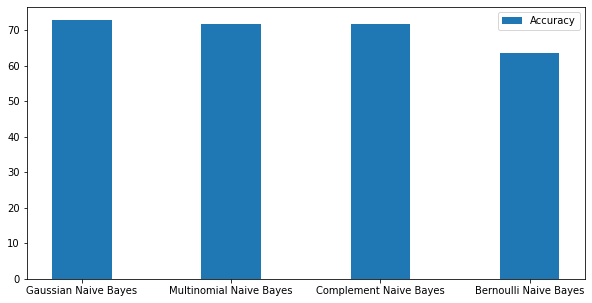

In [12]:
accuracy = {
    "Gaussian Naive Bayes": gnb_model.score(test_x, test_y),
    "Multinomial Naive Bayes": mnb_model.score(test_x, test_y),
    "Complement Naive Bayes": conb_model.score(test_x, test_y),
    "Bernoulli Naive Bayes": bnb_model.score(test_x, test_y)
}

modelNames=list(accuracy.keys())
acc=[x*100 for x in accuracy.values()]

xAxis=np.arange(len(modelNames))
plt.figure(figsize=(10,5))

plt.bar(xAxis, acc, width=0.4, label="Accuracy")
plt.xticks(xAxis, modelNames)
plt.legend()


plt.show()

### False negatives (deaths)

In [9]:
def analyzeConfusionMatrix(model, cm):
    falsePositiveRatio = cm[0][1]/sum(cm[0])*100
    print(model, 'falsely detected ', "{:.2f}".format(falsePositiveRatio), '% of sane patients as having pneumonia')
    deadRatio = cm[1][0]/sum(cm[1])*100
    print(model,' killed ',"{:.2f}".format(deadRatio), '% of the ill patients')
    print()
    return deadRatio

In [10]:
gnbCm = confusion_matrix(test_y, gnb_y_pred)
mnbCm = confusion_matrix(test_y, mnb_y_pred)
conbCm = confusion_matrix(test_y, conb_y_pred)
bnbCm = confusion_matrix(test_y, bnb_y_pred)

preds = {
    "Gaussian Naive Bayes": gnbCm,
    "Multinomial Naive Bayes": mnbCm,
    "Complement Naive Bayes": conbCm,
    "Bernoulli Naive Bayes": bnbCm
}

for key, value in preds.items():
    analyzeConfusionMatrix(key, value)

Gaussian Naive Bayes falsely detected  36.32 % of sane patients as having pneumonia
Gaussian Naive Bayes  killed  21.54 % of the ill patients

Multinomial Naive Bayes falsely detected  29.49 % of sane patients as having pneumonia
Multinomial Naive Bayes  killed  27.69 % of the ill patients

Complement Naive Bayes falsely detected  29.49 % of sane patients as having pneumonia
Complement Naive Bayes  killed  27.69 % of the ill patients

Bernoulli Naive Bayes falsely detected  41.45 % of sane patients as having pneumonia
Bernoulli Naive Bayes  killed  33.33 % of the ill patients



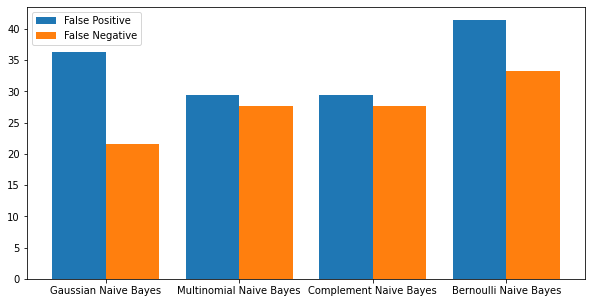

In [11]:
modelNames=list(preds.keys())
fp=[x[0][1]/sum(x[0])*100 for x in preds.values()]
fn=[x[1][0]/sum(x[1])*100 for x in preds.values()]

xAxis=np.arange(len(modelNames))
plt.figure(figsize=(10,5))

plt.bar(xAxis -0.2, fp, width=0.4, label="False Positive")
plt.bar(xAxis +0.2, fn, width=0.4, label="False Negative")
plt.xticks(xAxis, modelNames)
plt.legend()


plt.show()

## Gaussian Naive Bayes reign supreme
As expected, the Gaussian Naive Bayes is the best model since the other are made for multinomial distributions.

It is the best model by killing "only" 21% of the patients having pneumonia.

While the Gaussian Naive Bayes model has a slightly higher false positive ratio than the Multinomial and Complement, it has by far the lowest false negative (patient with pneumonia detected as sane) which is the most important metrics since it means the death of the patient.

